In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class SimpleBonds:
    def __init__(self,discounts,ZCB=None,ZCB_T= None,CPB= None,CPB_T=None,CPB_f=None,Principle = None):
        self.disct = discounts
        self.Prin = Principle
        if ZCB:
            self.Z = ZCB
            self.Z_T = ZCB_T
        if CPB: 
            self.C = CPB
            self.C_T = CPB_T
            self.C_f = CPB_f
        price = self.Price(ZCB=ZCB,ZCB_T= ZCB_T,CPB= CPB,CPB_T=CPB_T,CPB_f=CPB_f,Principle=Principle)
        self.Calc_DurConv()

    def Price(self,ZCB=None,ZCB_T= None,CPB= None,CPB_T=None,CPB_f=None,Principle = None):
        discounts = self.disct
        self.price = 0
        if ZCB:
            self.Z_price = discounts.loc[ZCB_T,"r"]*ZCB
            self.price += self.Z_price
            
        if CPB: 
            wdata = discounts.loc[discounts.index<=CPB_T,:]
            wdata = wdata.loc[wdata.index%CPB_f==0  ,"r"]
            self.C_payments = wdata*CPB/10

            if Principle:
                self.C_payments.iloc[-1] += 1000*wdata.iloc[-1]
            
            self.C_price = self.C_payments.sum()
            self.price += self.C_price

        if ZCB and CPB:
            self.C_payments.loc[ZCB_T] += self.Z_price
            self.C_price = self.C_payments.sum()
        return self.price
    
    def Calc_DurConv(self):
        try:
            self.weights = self.C_payments/self.C_payments.sum()
            self.dur = self.weights.mul(self.C_payments.index).sum()
            self.con = self.weights.mul(self.C_payments.index**2).sum()
        except:
            self.dur = self.Z_T
            self.con = self.Z_T**2
    def eval_price_change(self,dr):
        self.Calc_DurConv()
        return -dr*self.dur + self.dur*(dr**2)/2

class BondPort:
    def __init__(self,names,bonds,weights):
        self.names = names
        self.bonds = dict(zip(names,bonds))
        self.weights = dict(zip(names,weights))
        self.price()
        self.Calc_DurConv()
        pass
    
    def price(self):
        self.price = 0
        for name in self.names:
            self.price += self.bonds[name].price*self.weights[name]

    def Calc_DurConv(self):
        self.dur = 0
        self.con = 0
        for name in self.names:
            self.dur += self.bonds[name].dur*self.weights[name]
            self.con += self.bonds[name].con*self.weights[name]

    def eval_price_change(self,dr):
        change = 0
        for name in self.names:
            change += self.bonds[name].eval_price_change(dr)*self.weights[name]
        return change        
        


#### Question 1

,r
T,
0.25,0.994490
0.50,0.985555
0.75,0.973361
1.00,0.959637
1.25,0.944948
1.50,0.930252
1.75,0.915418
2.00,0.900325
2.25,0.885392


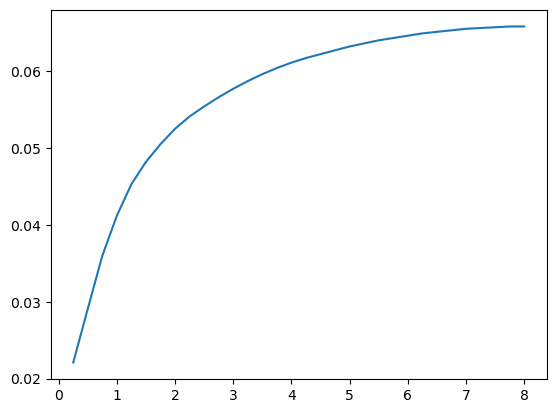

In [11]:
data = pd.read_csv("ISFdata.csv")
data.set_index("T",inplace = True)
discounts = np.exp(-data.mul(data.index,0))
plt.plot(data)
discounts


In [5]:
# Port A
# 3 months ZCB   
pA1 = SimpleBonds(discounts,1000,0.25)
# 5 year ZCB   
pA2 = SimpleBonds(discounts,1000,5)
# 6 year floating
pA3 = SimpleBonds(discounts,1000,0.5)
# 7 year floating + 30 bps
pA4 = SimpleBonds(discounts,1000,0.5,30,7,0.5)
# 4.5% (annual) 8 year bond 
pA5 = SimpleBonds(discounts,CPB=450,CPB_T=8,CPB_f=1,Principle=True)

In [6]:
# Port B
# 7.5% 6.25 year bonds
pB1 = SimpleBonds(discounts,CPB=750,CPB_T=6.25,CPB_f=0.5,Principle=True)
# 3.75 year ZCB
pB2 = SimpleBonds(discounts,1000,3.75)
# 5.75 year floating + 70 bps
pB3 = SimpleBonds(discounts,1000,0.5,70,5.75,0.5)
# 10% (annual) 7.75 year bonds
pB4 = SimpleBonds(discounts,CPB=1000,CPB_T=7.75,CPB_f=1,Principle=True)

In [13]:
dr = 0.5/100

PortA = BondPort(
    ["A1","A2","A3","A4","A5"],
    [pA1,pA2,pA3,pA4,pA5],
    [0.1,0.2,0.2,0.2,0.3]
)

PortB = BondPort(
    ["B1","B2","B3","B4"],
    [pB1,pB2,pB3,pB4],
    [0.25,0.15,0.3,0.3]
)


#### Question 4

In [15]:
ChangeA = PortA.eval_price_change(dr)
ChangeB = PortB.eval_price_change(dr)

print("Port A Change : {}".format(ChangeA))
print("Port B Change : {}".format(ChangeB))


Port A Change : -0.016339905237591556
Port B Change : -0.017507950582961524


#### Question 5&6

In [32]:
# 3 % (quarterly) 2 year bond
H1 = SimpleBonds(discounts,CPB=300/4,CPB_T=2,CPB_f=0.25,Principle=True)
# 7 year ZCB
H2 = SimpleBonds(discounts,1000,0.25)

X = np.matrix([[H1.dur,H2.dur],[H1.con,H2.con]])
bA = np.matrix([[PortA.dur],[PortA.con]])
bB = np.matrix([[PortB.dur],[PortB.con]])
pH = np.matrix([[H1.price],[H2.price]])

wA = np.linalg.pinv(X)@bA
wB = np.linalg.pinv(X)@bB

# a
costA = round((pH.T@np.abs(wA))[0,0],1)
costB = round((pH.T@np.abs(wB))[0,0],1)



hedging = pd.DataFrame(index = ["Port A", "Port B"], columns = ["H1","H2"])

hedging.loc["Port A",:] = wA.T
hedging.loc["Port B",:] = wB.T
hedging


,H1,H2
Port A,5.824139,-32.247795
Port B,5.261707,-26.931364


In [33]:
print("price to Hedge Port A :{}".format(costA))
print("price to Hedge Port B :{}".format(costB))

price to Hedge Port A :37645.9
price to Hedge Port B :31820.3
